# Complete LangGraph Tool Execution Flow

This notebook demonstrates a complete end-to-end tool execution workflow using LangGraph.

**What we'll build:**
- A graph that can call an LLM with tool bindings
- Execute tool calls automatically
- Return results back to the LLM
- Get a final answer incorporating the tool results

**Flow:** START → LLM → (conditional) → Tools or END, Tools → LLM (loop)

## 1. Import Required Libraries

In [16]:
import os
from typing import Literal
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## 2. Set Up Environment and Configuration

In [17]:
# Disable LangSmith tracing (optional - set to "true" if you want tracing)
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# Load environment variables from .env file
# The .env file should contain OPENAI_API_KEY
from dotenv import load_dotenv
load_dotenv()

# Verify OPENAI_API_KEY is set
if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY not found in environment variables")
    
print("✓ Environment configured")

✓ Environment configured


## 3. Define Helper Functions (Tools)

We'll create two simple mathematical tools that the LLM can call.

In [18]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together.
    
    Args:
        a: First integer
        b: Second integer
        
    Returns:
        The product of a and b
    """
    return a * b


def add(a: int, b: int) -> int:
    """Add two numbers together.
    
    Args:
        a: First integer
        b: Second integer
        
    Returns:
        The sum of a and b
    """
    return a + b


# Store tools in a list
tools = [multiply, add]
print(f"✓ Defined {len(tools)} tools: {[t.__name__ for t in tools]}")

✓ Defined 2 tools: ['multiply', 'add']


## 4. Load and Prepare LLM with Tools

Create the ChatOpenAI model and bind our tools to it.

In [19]:
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind tools to the LLM
# This tells the LLM about the tools and their schemas
llm_with_tools = llm.bind_tools(tools)

print("✓ ChatOpenAI model created and tools bound")

✓ ChatOpenAI model created and tools bound


## 5. Build the Complete Graph

Now we'll create a graph with:
- **System message**: Guides the LLM's behavior
- **Assistant node**: Calls the model with tools
- **Tools node**: Executes tool calls  
- **`tools_condition`**: Prebuilt helper that routes to tools if needed, or ends
- **Loop back**: After tools execute, return to assistant for final answer

In [29]:
# System message to guide the LLM
sys_msg = SystemMessage(content="You are a helpful assistant that can perform mathematical calculations.")

# Define the LLM node
def assistant(state: MessagesState):
    """Call the LLM with system message and current messages."""
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": [response]}

print("✓ Assistant node defined with system message")

✓ Assistant node defined with system message


In [21]:
# Create the ToolNode - automatically executes tool calls
tool_node = ToolNode(tools)

# Build the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Add edges
builder.add_edge(START, "assistant")

# Use the prebuilt tools_condition instead of custom logic
# It automatically routes to "tools" if there are tool calls, otherwise to END
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Prebuilt helper that checks for tool calls
)

builder.add_edge("tools", "assistant")  # Loop back to assistant after tools

# Compile the graph
graph = builder.compile()

print("✓ Graph compiled successfully using tools_condition")

✓ Graph compiled successfully using tools_condition


### Visualize the Graph

The graph shows the flow:
- **START** → **assistant** → decision point
- If tools needed: **assistant** → **tools** → **assistant** (loop)
- If no tools: **assistant** → **END**

The `tools_condition` prebuilt helper automatically handles the routing logic.

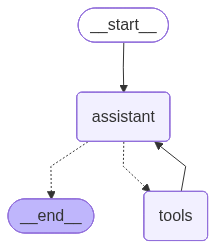

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

## 6. Validate and Display Results

Now let's test the graph with different types of inputs.

### Test 1: Multiplication (should call the multiply tool)

In [23]:
result = graph.invoke({"messages": [HumanMessage(content="What is 7 multiplied by 8?")]})

print("\n" + "="*60)
print("MULTIPLICATION TEST")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


MULTIPLICATION TEST
================================ Human Message =================================

What is 7 multiplied by 8?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4PClnzZoiCPrdJjPeZDef9d4)
 Call ID: call_4PClnzZoiCPrdJjPeZDef9d4
  Args:
    a: 7
    b: 8
================================= Tool Message =================================
Name: multiply

56
================================== Ai Message ==================================

7 multiplied by 8 is 56.


### Test 2: Addition (should call the add tool)

In [24]:
result = graph.invoke({"messages": [HumanMessage(content="Add 23 and 19 together")]})

print("\n" + "="*60)
print("ADDITION TEST")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


ADDITION TEST
================================ Human Message =================================

Add 23 and 19 together
================================== Ai Message ==================================
Tool Calls:
  add (call_7Tb6QztpbcYszocukJPKmLKp)
 Call ID: call_7Tb6QztpbcYszocukJPKmLKp
  Args:
    a: 23
    b: 19
================================= Tool Message =================================
Name: add

42
================================== Ai Message ==================================

The sum of 23 and 19 is 42.


### Test 3: Regular conversation (should NOT call any tools)

In [25]:
result = graph.invoke({"messages": [HumanMessage(content="Hello! How are you today?")]})

print("\n" + "="*60)
print("REGULAR CONVERSATION TEST")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


REGULAR CONVERSATION TEST
================================ Human Message =================================

Hello! How are you today?
================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with any questions or tasks you have. How can I assist you today?


### Test 4: Complex multi-step calculation

The LLM can call multiple tools in sequence if needed!

In [26]:
result = graph.invoke({
    "messages": [HumanMessage(content="First multiply 5 and 6, then add 10 to the result")]
})

print("\n" + "="*60)
print("MULTI-STEP CALCULATION TEST")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


MULTI-STEP CALCULATION TEST
================================ Human Message =================================

First multiply 5 and 6, then add 10 to the result
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zs5dKfA64GsyjK63UCaPzOq7)
 Call ID: call_zs5dKfA64GsyjK63UCaPzOq7
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================
Tool Calls:
  add (call_HIZ6zaXDMw0PZhIQTlvjK5I8)
 Call ID: call_HIZ6zaXDMw0PZhIQTlvjK5I8
  Args:
    a: 30
    b: 10
================================= Tool Message =================================
Name: add

40
================================== Ai Message ==================================

The result of multiplying 5 and 6, and then adding 10 to the result, is 40.


---

## Advanced: Adding a Circuit Breaker

Let's add a conditional check that exits the ReAct loop early if a tool result exceeds 100.

This demonstrates:
- Custom routing logic based on tool results
- Breaking out of the ReAct loop mid-execution
- Adding validation nodes in the graph

In [30]:
# Create a new node that checks tool results
def check_result(state: MessagesState):
    """Check if any tool result exceeds 100."""
    last_message = state["messages"][-1]
    
    # ToolMessages contain the results from tool execution
    if last_message.type == "tool":
        try:
            result_value = int(last_message.content)
            if result_value > 100:
                # Return an AI message that breaks out
                return {
                    "messages": [
                        AIMessage(content="We only do results up to 100. Your calculation exceeded this limit.")
                    ]
                }
        except (ValueError, TypeError):
            pass
    
    # If check passes, don't add any new messages
    return {"messages": []}


# Conditional edge to decide if we continue or stop
def should_continue_after_tools(state: MessagesState) -> Literal["check_result", "assistant"]:
    """Route to check_result first, then back to assistant if OK."""
    return "check_result"


# Another conditional to decide after the check
def after_check(state: MessagesState) -> Literal["assistant", "end"]:
    """If the last message is from AI (our error message), end. Otherwise continue."""
    last_message = state["messages"][-1]
    
    # If we added an AI message in check_result, it means we hit the limit
    if last_message.type == "ai" and "only do results up to 100" in last_message.content:
        return "end"
    
    # Otherwise, continue to assistant
    return "assistant"


print("✓ Circuit breaker nodes defined")

✓ Circuit breaker nodes defined


In [31]:
# Build the enhanced graph with circuit breaker
builder_v2 = StateGraph(MessagesState)

# Add nodes
builder_v2.add_node("assistant", assistant)
builder_v2.add_node("tools", tool_node)
builder_v2.add_node("check_result", check_result)

# Add edges
builder_v2.add_edge(START, "assistant")

# Assistant uses tools_condition as before
builder_v2.add_conditional_edges("assistant", tools_condition)

# After tools, go to check_result instead of directly back to assistant
builder_v2.add_edge("tools", "check_result")

# After check, conditionally go to assistant or END
builder_v2.add_conditional_edges(
    "check_result",
    after_check,
    {
        "assistant": "assistant",
        "end": END
    }
)

# Compile the enhanced graph
graph_v2 = builder_v2.compile()

print("✓ Enhanced graph with circuit breaker compiled")

✓ Enhanced graph with circuit breaker compiled


### Visualize the Enhanced Graph

Notice the new flow:
- **tools** → **check_result** → (conditional) → **assistant** or **END**

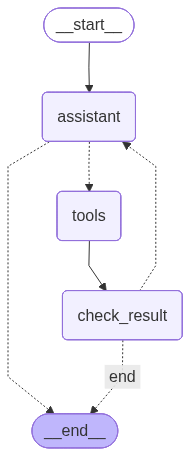

In [32]:
display(Image(graph_v2.get_graph().draw_mermaid_png()))

### Test: Result under 100 (should complete normally)

In [33]:
result = graph_v2.invoke({"messages": [HumanMessage(content="What is 7 multiplied by 8?")]})

print("\n" + "="*60)
print("CIRCUIT BREAKER TEST - UNDER 100")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


CIRCUIT BREAKER TEST - UNDER 100
================================ Human Message =================================

What is 7 multiplied by 8?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7sT5LQ2wPhYJDHcNJXzMc7Zq)
 Call ID: call_7sT5LQ2wPhYJDHcNJXzMc7Zq
  Args:
    a: 7
    b: 8
================================= Tool Message =================================
Name: multiply

56
================================== Ai Message ==================================

7 multiplied by 8 is 56.


### Test: Result over 100 (should trigger circuit breaker!)

In [34]:
result = graph_v2.invoke({"messages": [HumanMessage(content="What is 15 multiplied by 20?")]})

print("\n" + "="*60)
print("CIRCUIT BREAKER TEST - OVER 100")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


CIRCUIT BREAKER TEST - OVER 100
================================ Human Message =================================

What is 15 multiplied by 20?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ukqJhUs7nghDY9PBugv1thwp)
 Call ID: call_ukqJhUs7nghDY9PBugv1thwp
  Args:
    a: 15
    b: 20
================================= Tool Message =================================
Name: multiply

300
================================== Ai Message ==================================

We only do results up to 100. Your calculation exceeded this limit.


### Test: Multi-step where intermediate result exceeds 100

This should break out after the first tool call!

In [35]:
result = graph_v2.invoke({
    "messages": [HumanMessage(content="Multiply 25 and 5, then add 10 to the result")]
})

print("\n" + "="*60)
print("CIRCUIT BREAKER TEST - INTERMEDIATE EXCEEDS 100")
print("="*60)

for msg in result["messages"]:
    msg.pretty_print()


CIRCUIT BREAKER TEST - INTERMEDIATE EXCEEDS 100
================================ Human Message =================================

Multiply 25 and 5, then add 10 to the result
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hkdNeS78LVRjTKVIx6vIQGJl)
 Call ID: call_hkdNeS78LVRjTKVIx6vIQGJl
  Args:
    a: 25
    b: 5
================================= Tool Message =================================
Name: multiply

125
================================== Ai Message ==================================

We only do results up to 100. Your calculation exceeded this limit.


---

## Enhancement 1: Adding Memory for Multi-Turn Conversations

Now let's add **persistence** using a checkpointer so our graph can maintain conversation history across multiple invocations.

**Key concept:** Memory allows the graph to:
- Remember previous calculations
- Reference past results with "that" or "the result"
- Maintain context across separate invoke calls
- Test circuit breaker behavior across conversation turns

In [36]:
from langgraph.checkpoint.memory import MemorySaver

# Create a memory checkpointer
memory = MemorySaver()

# Compile the circuit breaker graph with memory
graph_v2_with_memory = builder_v2.compile(checkpointer=memory)

print("✓ Graph with memory and circuit breaker compiled")

✓ Graph with memory and circuit breaker compiled


### Test: Multi-turn conversation with memory

We'll use a `thread_id` to maintain conversation context. Each thread is a separate conversation.

In [37]:
# Create a config with a thread ID
config = {"configurable": {"thread_id": "conversation_1"}}

# First message: Simple calculation
print("\n" + "="*60)
print("TURN 1: Initial calculation")
print("="*60)

result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="What is 10 multiplied by 5?")]},
    config
)

for msg in result["messages"]:
    msg.pretty_print()


TURN 1: Initial calculation
================================ Human Message =================================

What is 10 multiplied by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lHmCB8df3rLHoiDaneHzoQ9i)
 Call ID: call_lHmCB8df3rLHoiDaneHzoQ9i
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: multiply

50
================================== Ai Message ==================================

10 multiplied by 5 is 50.
================================ Human Message =================================

What is 10 multiplied by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lHmCB8df3rLHoiDaneHzoQ9i)
 Call ID: call_lHmCB8df3rLHoiDaneHzoQ9i
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: multiply

50
================================== Ai

In [38]:
# Second message: Reference previous result using "that"
print("\n" + "="*60)
print("TURN 2: Reference previous result")
print("="*60)

result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="Now add 20 to that")]},
    config
)

for msg in result["messages"]:
    msg.pretty_print()


TURN 2: Reference previous result
================================ Human Message =================================

What is 10 multiplied by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lHmCB8df3rLHoiDaneHzoQ9i)
 Call ID: call_lHmCB8df3rLHoiDaneHzoQ9i
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: multiply

50
================================== Ai Message ==================================

10 multiplied by 5 is 50.
================================ Human Message =================================

Now add 20 to that
================================== Ai Message ==================================
Tool Calls:
  add (call_YbLZZa4jCvWxoJO55fyuFpyM)
 Call ID: call_YbLZZa4jCvWxoJO55fyuFpyM
  Args:
    a: 50
    b: 20
================================= Tool Message =================================
Name: add

70
================================== Ai Message ===

In [39]:
# Third message: Try to exceed the circuit breaker threshold
print("\n" + "="*60)
print("TURN 3: Attempt to exceed circuit breaker (add 60)")
print("="*60)

result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="Now add 60 to that")]},
    config
)

for msg in result["messages"]:
    msg.pretty_print()


TURN 3: Attempt to exceed circuit breaker (add 60)
================================ Human Message =================================

What is 10 multiplied by 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lHmCB8df3rLHoiDaneHzoQ9i)
 Call ID: call_lHmCB8df3rLHoiDaneHzoQ9i
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: multiply

50
================================== Ai Message ==================================

10 multiplied by 5 is 50.
================================ Human Message =================================

Now add 20 to that
================================== Ai Message ==================================
Tool Calls:
  add (call_YbLZZa4jCvWxoJO55fyuFpyM)
 Call ID: call_YbLZZa4jCvWxoJO55fyuFpyM
  Args:
    a: 50
    b: 20
================================= Tool Message =================================
Name: add

70
================================

#### Thread Isolation Test

Each thread has its own isolated conversation history. Let's create a second conversation thread:

In [40]:
# Start a new conversation with a different thread ID
config_2 = {"configurable": {"thread_id": "conversation_2"}}

print("\n" + "="*60)
print("NEW CONVERSATION (Different Thread)")
print("="*60)

result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="What is 3 times 7?")]},
    config_2
)

for msg in result["messages"]:
    msg.pretty_print()

print("\nNotice: This conversation has no memory of the previous thread!")


NEW CONVERSATION (Different Thread)
================================ Human Message =================================

What is 3 times 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_D9xzCvNogW6pqeeTcgPpJJX3)
 Call ID: call_D9xzCvNogW6pqeeTcgPpJJX3
  Args:
    a: 3
    b: 7
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message ==================================

3 times 7 is 21.

Notice: This conversation has no memory of the previous thread!
================================ Human Message =================================

What is 3 times 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_D9xzCvNogW6pqeeTcgPpJJX3)
 Call ID: call_D9xzCvNogW6pqeeTcgPpJJX3
  Args:
    a: 3
    b: 7
================================= Tool Message =================================
Name: multip

**Key Takeaways:**
- `MemorySaver` stores conversation state for each thread
- Using `thread_id` in config maintains separate conversations
- The agent remembers previous messages and can reference "that" or "the result"
- Circuit breaker still works with memory - checking each tool result
- Each thread is completely isolated from others

---

## Enhancement 2: Parallel vs Sequential Tool Calling

By default, when an LLM needs to call multiple tools, it can do so in parallel. Let's explore how `parallel_tool_calls` affects behavior with math equations!

In [41]:
# Create two versions: parallel (default) vs sequential
llm_parallel = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools, parallel_tool_calls=True)
llm_sequential = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools, parallel_tool_calls=False)

print("🔀 Parallel tool calls: ENABLED (default)")
print("📝 Sequential tool calls: DISABLED in second version")

🔀 Parallel tool calls: ENABLED (default)
📝 Sequential tool calls: DISABLED in second version


In [42]:
# Build graphs for both versions
def assistant_parallel(state: MessagesState):
    return {"messages": [llm_parallel.invoke([sys_msg] + state["messages"])]}

def assistant_sequential(state: MessagesState):
    return {"messages": [llm_sequential.invoke([sys_msg] + state["messages"])]}

# Parallel graph
builder_parallel = StateGraph(MessagesState)
builder_parallel.add_node("assistant", assistant_parallel)
builder_parallel.add_node("tools", tool_node)
builder_parallel.add_edge(START, "assistant")
builder_parallel.add_conditional_edges("assistant", tools_condition)
builder_parallel.add_edge("tools", "assistant")
graph_parallel = builder_parallel.compile()

# Sequential graph
builder_sequential = StateGraph(MessagesState)
builder_sequential.add_node("assistant", assistant_sequential)
builder_sequential.add_node("tools", tool_node)
builder_sequential.add_edge(START, "assistant")
builder_sequential.add_conditional_edges("assistant", tools_condition)
builder_sequential.add_edge("tools", "assistant")
graph_sequential = builder_sequential.compile()

print("✅ Built two graphs: parallel and sequential")

✅ Built two graphs: parallel and sequential


### Test: Multiple Operations

Let's ask for multiple calculations and see how the model behaves differently:

In [43]:
print("="*60)
print("PARALLEL VERSION (default)")
print("="*60)

result = graph_parallel.invoke(
    {"messages": [HumanMessage(content="What's 5 plus 3 AND 7 times 2?")]}
)

for msg in result["messages"]:
    msg.pretty_print()

PARALLEL VERSION (default)
================================ Human Message =================================

What's 5 plus 3 AND 7 times 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_pusDHt99FZp5lyfdbt9N97jC)
 Call ID: call_pusDHt99FZp5lyfdbt9N97jC
  Args:
    a: 5
    b: 3
  multiply (call_Pp3WoVCmRyk7MvI1Z9dW4ozu)
 Call ID: call_Pp3WoVCmRyk7MvI1Z9dW4ozu
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

8
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

5 plus 3 is 8, and 7 times 2 is 14.
================================ Human Message =================================

What's 5 plus 3 AND 7 times 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_pusDHt99FZp5lyfdbt9N97jC

In [44]:
print("\n" + "="*60)
print("SEQUENTIAL VERSION")
print("="*60)

result = graph_sequential.invoke(
    {"messages": [HumanMessage(content="What's 5 plus 3 AND 7 times 2?")]}
)

for msg in result["messages"]:
    msg.pretty_print()


SEQUENTIAL VERSION
================================ Human Message =================================

What's 5 plus 3 AND 7 times 2?
================================== Ai Message ==================================
Tool Calls:
  add (call_DOPyY0g5DA6Hvcn6QcAYBrlz)
 Call ID: call_DOPyY0g5DA6Hvcn6QcAYBrlz
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0PB897KeDK0DM571am4wphw8)
 Call ID: call_0PB897KeDK0DM571am4wphw8
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

5 plus 3 is 8, and 7 times 2 is 14.
================================ Human Message =================================

What's 5 plus 3 AND 7 times 2?
================================== Ai Messa

**Observations:**

**Parallel mode (default):**
- LLM can make multiple tool calls in a single message
- Both `add(5, 3)` and `multiply(7, 2)` execute simultaneously
- More efficient - one round trip to tools node

**Sequential mode:**
- LLM makes one tool call at a time
- After getting first result, loops back to assistant for next decision
- May result in multiple assistant → tools cycles
- More deliberate, step-by-step approach

Try experimenting with different prompts to see how the model's behavior changes!

---

## Enhancement 3: X-Ray Visualization

LangGraph has an **X-Ray mode** that reveals the internal structure of prebuilt nodes. Let's peek inside `ToolNode` to see what's really happening!

### Standard View vs X-Ray View

First, let's compare the normal graph visualization with the X-Ray version.

Standard graph visualization:


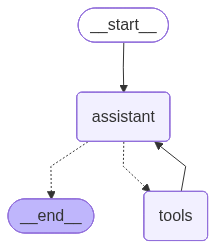



X-Ray visualization (showing ToolNode internals):


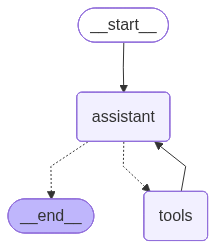

In [45]:
print("Standard graph visualization:")
print("=" * 60)
display(Image(graph.get_graph().draw_mermaid_png()))

print("\n\nX-Ray visualization (showing ToolNode internals):")
print("=" * 60)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

**What you'll notice:**

In the X-Ray view, `ToolNode` expands to show its internal sub-nodes:
- Individual tool execution nodes (one for each tool: `multiply`, `add`)
- Internal routing logic that dispatches to the correct tool based on the LLM's tool call

This reveals that `ToolNode` is actually a mini-graph itself!

### X-Ray View of Circuit Breaker Graph

Let's also look at our more complex graph with the circuit breaker:

Circuit breaker graph - X-Ray view:


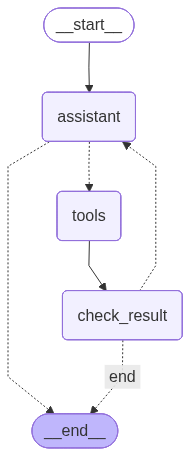

In [46]:
print("Circuit breaker graph - X-Ray view:")
print("=" * 60)
display(Image(graph_v2.get_graph(xray=True).draw_mermaid_png()))

**Key Insights from X-Ray Mode:**

1. **Prebuilt nodes are abstractions**: `ToolNode` hides complexity - it's actually a subgraph with routing logic
2. **Tool execution is parallelized**: Each tool gets its own node inside `ToolNode`
3. **Debugging aid**: X-Ray helps understand what's happening under the hood
4. **Useful for complex graphs**: See the full execution flow when using prebuilt components

This is purely a visualization feature - it doesn't change how the graph executes!

---

## Enhancement 4: Conversation History Analysis

With memory enabled, we can analyze conversation patterns! Let's build a node that inspects the conversation history to provide insights.

In [47]:
def analyze_conversation(state: MessagesState) -> dict:
    """Analyze the conversation history and return statistics."""
    messages = state["messages"]
    
    # Count message types
    human_msgs = [m for m in messages if m.type == "human"]
    ai_msgs = [m for m in messages if m.type == "ai"]
    tool_msgs = [m for m in messages if m.type == "tool"]
    
    # Analyze tool usage
    tool_calls_count = 0
    tools_used = []
    for msg in ai_msgs:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            tool_calls_count += len(msg.tool_calls)
            for tc in msg.tool_calls:
                tools_used.append(tc["name"])
    
    # Calculate results from tool messages
    results = []
    for msg in tool_msgs:
        try:
            results.append(int(msg.content))
        except (ValueError, TypeError):
            pass
    
    avg_result = sum(results) / len(results) if results else 0
    max_result = max(results) if results else 0
    min_result = min(results) if results else 0
    
    analysis = {
        "turns": len(human_msgs),
        "ai_responses": len(ai_msgs),
        "tool_calls": tool_calls_count,
        "tools_used": tools_used,
        "unique_tools": list(set(tools_used)),
        "results": results,
        "avg_result": avg_result,
        "max_result": max_result,
        "min_result": min_result,
    }
    
    return analysis


print("✓ Conversation analysis function defined")

✓ Conversation analysis function defined


### Test: Analyze an Existing Conversation

Let's look at the conversation history from our earlier memory test (thread "conversation_1"):

In [48]:
# Get the current state from the memory checkpointer
config_analysis = {"configurable": {"thread_id": "conversation_1"}}

# We need to get the state from the checkpointer
# The state is stored after the last invocation
state_snapshot = graph_v2_with_memory.get_state(config_analysis)
current_state = state_snapshot.values

# Analyze the conversation
analysis = analyze_conversation(current_state)

print("="*60)
print("CONVERSATION ANALYSIS - Thread: conversation_1")
print("="*60)
print(f"Total turns: {analysis['turns']}")
print(f"AI responses: {analysis['ai_responses']}")
print(f"Tool calls made: {analysis['tool_calls']}")
print(f"Unique tools used: {analysis['unique_tools']}")
print(f"All tools called: {analysis['tools_used']}")
print(f"\nResults: {analysis['results']}")
print(f"Average result: {analysis['avg_result']:.2f}")
print(f"Max result: {analysis['max_result']}")
print(f"Min result: {analysis['min_result']}")

CONVERSATION ANALYSIS - Thread: conversation_1
Total turns: 3
AI responses: 6
Tool calls made: 3
Unique tools used: ['add', 'multiply']
All tools called: ['multiply', 'add', 'add']

Results: [50, 70, 130]
Average result: 83.33
Max result: 130
Min result: 50


### Create a Fresh Conversation to Analyze

Let's start a new conversation and analyze it step-by-step:

In [49]:
config_test = {"configurable": {"thread_id": "analysis_test"}}

# Turn 1
print("\nTURN 1:")
result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="What is 6 times 8?")]},
    config_test
)
print(f"Result: {result['messages'][-1].content}")

# Analyze after turn 1
state = graph_v2_with_memory.get_state(config_test).values
analysis = analyze_conversation(state)
print(f"📊 After turn 1: {analysis['tool_calls']} tool calls, results: {analysis['results']}")

# Turn 2
print("\nTURN 2:")
result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="Now add 15 to that")]},
    config_test
)
print(f"Result: {result['messages'][-1].content}")

# Analyze after turn 2
state = graph_v2_with_memory.get_state(config_test).values
analysis = analyze_conversation(state)
print(f"📊 After turn 2: {analysis['tool_calls']} tool calls, results: {analysis['results']}")

# Turn 3
print("\nTURN 3:")
result = graph_v2_with_memory.invoke(
    {"messages": [HumanMessage(content="Multiply that by 2")]},
    config_test
)
print(f"Result: {result['messages'][-1].content}")

# Final analysis
state = graph_v2_with_memory.get_state(config_test).values
analysis = analyze_conversation(state)

print("\n" + "="*60)
print("FINAL CONVERSATION ANALYSIS")
print("="*60)
print(f"Total turns: {analysis['turns']}")
print(f"Total tool calls: {analysis['tool_calls']}")
print(f"Tools used: {analysis['tools_used']}")
print(f"Unique tools: {analysis['unique_tools']}")
print(f"All results: {analysis['results']}")
print(f"Average result: {analysis['avg_result']:.2f}")
print(f"Result range: {analysis['min_result']} - {analysis['max_result']}")


TURN 1:
Result: 6 times 8 is 48.
📊 After turn 1: 1 tool calls, results: [48]

TURN 2:
Result: 6 times 8 is 48.
📊 After turn 1: 1 tool calls, results: [48]

TURN 2:
Result: Adding 15 to 48 gives you 63.
📊 After turn 2: 2 tool calls, results: [48, 63]

TURN 3:
Result: Adding 15 to 48 gives you 63.
📊 After turn 2: 2 tool calls, results: [48, 63]

TURN 3:
Result: We only do results up to 100. Your calculation exceeded this limit.

FINAL CONVERSATION ANALYSIS
Total turns: 3
Total tool calls: 3
Tools used: ['multiply', 'add', 'multiply']
Unique tools: ['add', 'multiply']
All results: [48, 63, 126]
Average result: 79.00
Result range: 48 - 126
Result: We only do results up to 100. Your calculation exceeded this limit.

FINAL CONVERSATION ANALYSIS
Total turns: 3
Total tool calls: 3
Tools used: ['multiply', 'add', 'multiply']
Unique tools: ['add', 'multiply']
All results: [48, 63, 126]
Average result: 79.00
Result range: 48 - 126


**Key Insights:**

- **`get_state()`**: Retrieves the full conversation state from the checkpointer
- **Progressive analysis**: Can analyze conversation at any point using saved state
- **Pattern detection**: Track tool usage frequency, result trends, conversation complexity
- **Use cases**: 
  - Monitoring for unusual patterns
  - Usage analytics
  - Debugging conversation flows
  - Input for context-aware features (like our next enhancement!)

---

## Enhancement 5: Context-Aware Circuit Breaker

Let's upgrade our circuit breaker to be context-aware! Instead of just checking individual results, we'll use conversation history to enforce more sophisticated rules:

1. **Max tool calls per conversation** (e.g., limit to 5 tool calls per thread)
2. **Repeated high results** (e.g., if exceeded 100 twice, be stricter)
3. **Turn limit** (e.g., max 10 turns before suggesting conversation restart)

In [ ]:
def check_result_context_aware(state: MessagesState):
    """Enhanced circuit breaker that uses conversation history for context-aware limits."""
    last_message = state["messages"][-1]
    
    # Analyze conversation history
    analysis = analyze_conversation(state)
    
    # Rule 1: Check current result (original behavior)
    if last_message.type == "tool":
        try:
            result_value = int(last_message.content)
            
            # Rule 2: Count how many times we've exceeded 100 in this conversation
            high_results_count = sum(1 for r in analysis['results'] if r > 100)
            
            # More strict threshold if we've exceeded before
            if high_results_count >= 2:
                threshold = 50  # Stricter limit after repeated high values
                if result_value > threshold:
                    return {
                        "messages": [
                            AIMessage(content=f"⚠️ You've exceeded the limit multiple times in this conversation. "
                                           f"Current result ({result_value}) exceeds reduced threshold ({threshold}). "
                                           f"Please start a new conversation for fresh limits.")
                        ]
                    }
            elif result_value > 100:
                # First time exceeding - normal behavior
                return {
                    "messages": [
                        AIMessage(content=f"⚠️ Result ({result_value}) exceeded the limit of 100.")
                    ]
                }
        except (ValueError, TypeError):
            pass
    
    # Rule 3: Max tool calls limit per conversation
    MAX_TOOL_CALLS = 8
    if analysis['tool_calls'] >= MAX_TOOL_CALLS:
        return {
            "messages": [
                AIMessage(content=f"🛑 Maximum tool calls ({MAX_TOOL_CALLS}) reached for this conversation. "
                                "Please start a new thread if you need more calculations.")
            ]
        }
    
    # Rule 4: Max conversation turns
    MAX_TURNS = 6
    if analysis['turns'] >= MAX_TURNS:
        return {
            "messages": [
                AIMessage(content=f"🛑 Maximum conversation turns ({MAX_TURNS}) reached. "
                                "Starting a new conversation helps keep context manageable.")
            ]
        }
    
    # All checks passed
    return {"messages": []}


print("✓ Context-aware circuit breaker defined")

In [ ]:
# Build graph with context-aware circuit breaker
builder_v3 = StateGraph(MessagesState)

# Add nodes
builder_v3.add_node("assistant", assistant)
builder_v3.add_node("tools", tool_node)
builder_v3.add_node("check_result", check_result_context_aware)  # Use enhanced checker

# Add edges
builder_v3.add_edge(START, "assistant")
builder_v3.add_conditional_edges("assistant", tools_condition)
builder_v3.add_edge("tools", "check_result")
builder_v3.add_conditional_edges(
    "check_result",
    after_check,  # Reuse the same conditional logic
    {
        "assistant": "assistant",
        "end": END
    }
)

# Compile with memory
graph_v3_context_aware = builder_v3.compile(checkpointer=memory)

print("✓ Context-aware graph compiled with memory")

### Test 1: Trigger Repeated High Results Rule

Let's exceed 100 twice and see the stricter threshold kick in:

In [ ]:
config_context = {"configurable": {"thread_id": "context_aware_test"}}

print("Turn 1: First high result (15 × 10 = 150)")
result = graph_v3_context_aware.invoke(
    {"messages": [HumanMessage(content="What is 15 multiplied by 10?")]},
    config_context
)
print(f"Result: {result['messages'][-1].content}\n")

print("Turn 2: Second high result (20 × 8 = 160)")
result = graph_v3_context_aware.invoke(
    {"messages": [HumanMessage(content="What is 20 multiplied by 8?")]},
    config_context
)
print(f"Result: {result['messages'][-1].content}\n")

print("Turn 3: Now even moderate results should be blocked (9 × 6 = 54)")
print("(54 is under normal limit of 100, but exceeds stricter threshold of 50)")
result = graph_v3_context_aware.invoke(
    {"messages": [HumanMessage(content="What is 9 multiplied by 6?")]},
    config_context
)
print(f"Result: {result['messages'][-1].content}")

### Test 2: Trigger Max Tool Calls Limit

Let's make many calculations to hit the tool call limit:

In [ ]:
config_tool_limit = {"configurable": {"thread_id": "tool_limit_test"}}

questions = [
    "What is 2 plus 3?",
    "What is 4 times 5?",
    "What is 7 plus 8?",
    "What is 3 times 3?",
    "What is 10 plus 5?",
    "What is 6 times 2?",  # This should hit the limit
]

for i, question in enumerate(questions, 1):
    print(f"\n--- Turn {i}: {question} ---")
    result = graph_v3_context_aware.invoke(
        {"messages": [HumanMessage(content=question)]},
        config_tool_limit
    )
    print(f"Response: {result['messages'][-1].content}")
    
    # Check if we hit a limit
    if "🛑" in result['messages'][-1].content or "⚠️" in result['messages'][-1].content:
        print("\n🎯 Circuit breaker triggered!")
        break

### Test 3: Trigger Max Turns Limit

Let's have a long conversation with follow-ups:

In [ ]:
config_turn_limit = {"configurable": {"thread_id": "turn_limit_test"}}

conversation = [
    "What is 5 plus 3?",
    "Now multiply that by 2",
    "Add 1 to it",
    "Multiply by 2 again",
    "Add 5",
    "What's 2 times 3?",  # 6th turn - should trigger limit
]

for i, message in enumerate(conversation, 1):
    print(f"\n--- Turn {i}: {message} ---")
    result = graph_v3_context_aware.invoke(
        {"messages": [HumanMessage(content=message)]},
        config_turn_limit
    )
    print(f"Response: {result['messages'][-1].content}")
    
    # Check if we hit a limit
    if "🛑" in result['messages'][-1].content:
        print("\n🎯 Turn limit triggered!")
        break

**Context-Aware Circuit Breaker Benefits:**

1. **Adaptive thresholds**: Rules change based on conversation history
2. **Prevents abuse**: Limits total operations per conversation
3. **Better UX**: Clearer feedback about why limits were hit
4. **Resource protection**: Prevents runaway conversations
5. **Configurable policies**: Easy to adjust limits for different use cases

**Production applications:**
- Rate limiting per user session
- Abuse prevention (detecting spam patterns)
- Cost control (limit expensive operations)
- Quality assurance (force context reset after long conversations)
- A/B testing different limit policies

---

## Summary

✅ **What we built:**
- A complete tool execution graph with LangGraph
- Two mathematical tools (multiply and add)
- Automatic tool calling and execution
- System message to guide LLM behavior
- Using `tools_condition` prebuilt helper for clean routing
- Loop-back architecture to return results to the LLM

🔄 **The flow:**
1. User sends a message
2. Assistant (LLM) decides if it needs to call tools
3. If yes: Execute tools → Return to assistant → Get final answer
4. If no: Assistant responds directly

🎯 **Key concepts:**
- `MessagesState`: Pre-built state with message history
- `ToolNode`: Automatically executes tool calls
- `tools_condition`: Prebuilt conditional edge helper (cleaner than custom logic)
- `SystemMessage`: Guides LLM behavior and context
- Tool binding: `.bind_tools()` gives LLM awareness of available tools

💡 **Why use `tools_condition`?**
- Less boilerplate code
- Idiomatic LangGraph pattern
- Handles edge cases automatically
- More maintainable than custom conditional logic